In [13]:
from rich.logging import RichHandler
import logging
from lightning_lite.utilities.seed import seed_everything
from shell_data.dataset.dataset import get_train_val_test_subsets
import torch
import os
from shell_data.utils.config import (
    ShELLDataSharingConfig,
    DatasetConfig,
    TaskModelConfig,
    TrainingConfig,
    ExperienceReplayConfig,
)
from shell_data.shell_agent.shell_agent_classification import ShELLClassificationAgent

import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import umap
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"
torch.use_deterministic_algorithms(True)
seed_everything(0)

logging.basicConfig(level=logging.DEBUG,
                    format="%(message)s",
                    handlers=[RichHandler(rich_tracebacks=True, markup=False, show_time=False, show_path=False)],)

Global seed set to 0


In [14]:
def to_features(X):
    return X.view(X.size(0), -1)

def dist(X, X2, p=2):
    return torch.cdist(to_features(X), to_features(X2), p=p)

def get_xy(dataset):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset))
    return next(iter(dataloader))

In [15]:
dataset_name = "fashion_mnist"
train_subsets, val_subsets, test_subsets = get_train_val_test_subsets(
    dataset_name)
size = 128
num_cls_per_task = 4

cfg = ShELLDataSharingConfig(
    n_agents=1,
    dataset=DatasetConfig(
        name=dataset_name,
        train_size=size,
        val_size=min(size, min([len(d) for d in val_subsets])),
        num_task_per_life=2,
        num_cls_per_task=num_cls_per_task,
    ),
    task_model=TaskModelConfig(
        name=dataset_name,
    ),
    training=TrainingConfig(
        n_epochs=100,
    ),
    experience_replay=ExperienceReplayConfig(
            train_size=50000,
        ),
)

In [16]:
sender = ShELLClassificationAgent(
        train_subsets, val_subsets, test_subsets, cfg,
        enable_validate_config=False,)

receiver = ShELLClassificationAgent(
        train_subsets, val_subsets, test_subsets, cfg,
        enable_validate_config=False,)

sender.ll_dataset.perm = torch.tensor([5, 1, 0, 7])  # should send 5 then 7
receiver.ll_dataset.perm = torch.tensor([5, 1, 0, 7])

In [17]:
# receiver should train on task 0
print("test before training", receiver.test(0))
receiver.learn_task(0)
print("test after training", receiver.test(0))

test before training 0.06125
test after training 0.94725


In [18]:
[len(b) for b in receiver.buffer.buffers]

[128, 128, 0, 0, 0, 128, 0, 128, 0, 0]

In [19]:
sender_data = []

for t in range(2):
    sender_data.append(sender.ll_dataset.get_train_dataset(t))

sender_data = torch.utils.data.ConcatDataset(sender_data)

sender_x, sender_y = get_xy(sender_data)

AssertionError: datasets should not be an empty iterable

In [8]:
receiver.buffer.add_data((sender_x[sender_y == 5], sender_y[sender_y == 5]))
# receiver.buffer.add_data((sender_x[sender_y == 7], sender_y[sender_y == 7]))
# receiver.buffer.add_data((sender_x[sender_y == 0], sender_y[sender_y == 0]))
receiver.buffer.add_data((sender_x[sender_y == 1], sender_y[sender_y == 1]))
[len(b) for b in receiver.buffer.buffers]

[0, 256, 0, 0, 0, 256, 0, 0, 0, 0]

In [9]:
receiver.learn_from_buffer(ll_time=0)

In [10]:
receiver.test(0)

0.9975

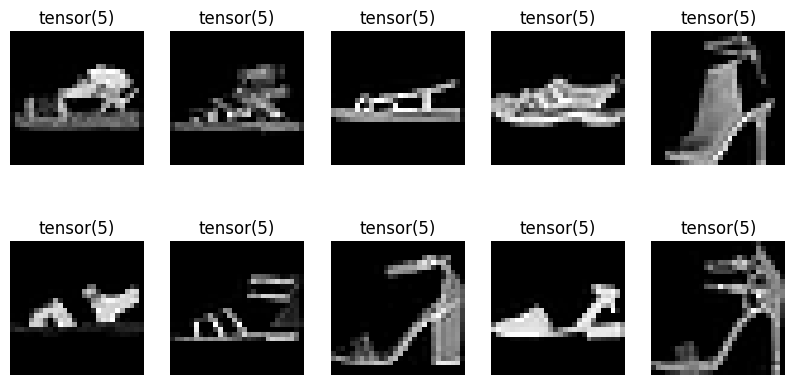

In [12]:
test_dataset = receiver.ll_dataset.get_test_dataset(0)

# plot 10 random images
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i in range(10):
    ax = axs[i // 5, i % 5]
    ax.imshow(test_dataset[i][0].view(28, 28), cmap="gray")
    ax.set_title(test_dataset[i][1])
    ax.axis("off")